In [28]:
from ultralytics import YOLO
import ultralytics
from pathlib import Path
import pandas as pd
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from PIL import Image

DATASET_BASE_NAME = "Weed-crop RGB dataset" 
TARGET_CROP_NAME = "Black bean"    

# --- MODEL AND TRAINING CONSTANTS ---
MODEL_NAME = "yolo11n.pt"  # Base model weights to be used
IMG_SIZE = 640             # Image size for training/testing
BATCH_SIZE = 4             # Batch size
EPOCHS = 100               # Number of epochs
PATIENCE = 20              # Early stopping patience
DEVICE_ID = 0              # GPU device ID (e.g., 0)
RUNS_BASE_DIR = Path("runs") # Parent directory for all YOLO results

# --- DATASET CONFIGURATION (Dynamic Paths) ---
DATASET_ROOT = Path(DATASET_BASE_NAME)
AUG_DIR_NAME = f"{TARGET_CROP_NAME}_augmented"
DATA_CONFIG_AUG = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_augmented.yaml" 
DATA_CONFIG_ORIGINAL = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_original.yaml" 
CLASSES_FILE = DATASET_ROOT / AUG_DIR_NAME / "classes.txt"
JSON_FILE_PATH = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_stats.json"

ORIGINAL_PROJECT_NAME = f"{TARGET_CROP_NAME}_original"
AUGMENTED_PROJECT_NAME = f"{TARGET_CROP_NAME}_augmented"

ORIGINAL_OUTPUT_DIR = RUNS_BASE_DIR / ORIGINAL_PROJECT_NAME

AUGMENTED_OUTPUT_DIR = RUNS_BASE_DIR / AUGMENTED_PROJECT_NAME

def get_final_paths(base_path, experiment_name):
    run_folder = base_path / experiment_name 
    return {
        'weights': run_folder / 'weights' / 'best.pt',
        'plot_pr': run_folder / 'evaluation' / 'BoxPR_curve.png',
        'plot_res': run_folder / 'results.png',
        'plot_cm': run_folder / 'evaluation' / 'confusion_matrix_normalized.png',
    }

ORIGINAL_PATHS = get_final_paths(RUNS_BASE_DIR, ORIGINAL_PROJECT_NAME)
AUGMENTED_PATHS = get_final_paths(RUNS_BASE_DIR, AUGMENTED_PROJECT_NAME)

# Ablation Study: Original vs Augmented Dataset

This notebook performs an ablation study to evaluate the impact of context-aware undersampling on YOLO11n model performance. We compare two training scenarios:

1. **Original Dataset:** Model trained on the unmodified Black bean dataset with severe class imbalance
2. **Augmented Dataset:** Model trained on the preprocessed dataset with balanced class distribution

The study aims to determine whether reducing the majority class (Black bean) through intelligent undersampling improves detection performance for minority weed classes without critically compromising overall accuracy.

## Experimental Setup

**Model Configuration:**
- Base Architecture: YOLO11n (yolo11n.pt)
- Input Size: 640x640 pixels
- Training: 150 epochs, batch size 4, early stopping disabled (patience=0)
- Hardware: GPU-based training (device_id=0)

**Dataset:**
- Source: Mendeley Weed-crop RGB dataset
- Target Crop: Black bean
- Classes: 5 weed species (Horseweed, Kochia, Ragweed, Redroot Pigweed, Waterhemp) + crop species

# Ablation study - what do we expect to happen?

The core challenge in applying object detection to this agricultural dataset is the severe class imbalance between the majority crop and the minority weed classes. To address this, we implemented a context-aware undersampling strategy focused on mitigating noise caused by low-context crop instances at image borders. This targeted preprocessing successfully reduced the majority class (Black bean) instance count by 48.3% overall (from 1382 to 715 total instances), corresponding to a 47.7% reduction in the training split (from 1727 to 903 instances). We expect the model trained on augmented data to achieve better performance on minority weed class detection due to reduced class imbalance, while maintaining comparable overall accuracy. 

In [5]:
def load_class_names_from_file(file_path):
    with open(file_path, 'r') as f:
        class_names = {str(i): line.strip() for i, line in enumerate(f)}
    return class_names

CLASS_NAMES = load_class_names_from_file(CLASSES_FILE)
with open(JSON_FILE_PATH, 'r') as f:
    stats_data = json.load(f)

df_stats = pd.DataFrame.from_dict(stats_data, orient='index').T
df_stats = df_stats.fillna(0).astype(int) 
df_stats['deleted instances'] = df_stats['train'] - df_stats['train_augmented']
new_index_names = [CLASS_NAMES.get(idx, idx) for idx in df_stats.index.astype(str)]
df_stats.index = new_index_names
columns_to_display = ['train', 'train_augmented', 'deleted instances']
print("--- Detailed Class Distribution and Augmentation Impact ---")
display(df_stats[columns_to_display])

--- Detailed Class Distribution and Augmentation Impact ---


,train,train_augmented,deleted instances
Redroot Pigweed,80,80,0
Kochia,85,85,0
Black bean,1727,903,824
Waterhemp,95,95,0
Ragweed,99,99,0
Horseweed,50,50,0
Soybean,20,19,1
Flax,0,0,0
Lentil,0,0,0


## Class Distribution Analysis

The table below shows the impact of context-aware undersampling on the training set. The preprocessing algorithm targeted low-context Black bean instances at image borders while preserving all minority weed classes.

# Model training on Original Dataset

---

# Training Phase

Two separate YOLO11n models are trained from scratch using identical hyperparameters. The only difference is the training dataset: one uses the original unbalanced data, the other uses the augmented balanced data.

In [6]:
original_model = YOLO(MODEL_NAME)

baseline_train_results = original_model.train(
    data=str(DATA_CONFIG_ORIGINAL),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=ORIGINAL_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE,
    #workers=0,
    exist_ok=True
)

print(f"Original dataset model saved to: {ORIGINAL_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Black bean_augmented/black bean_original.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, m

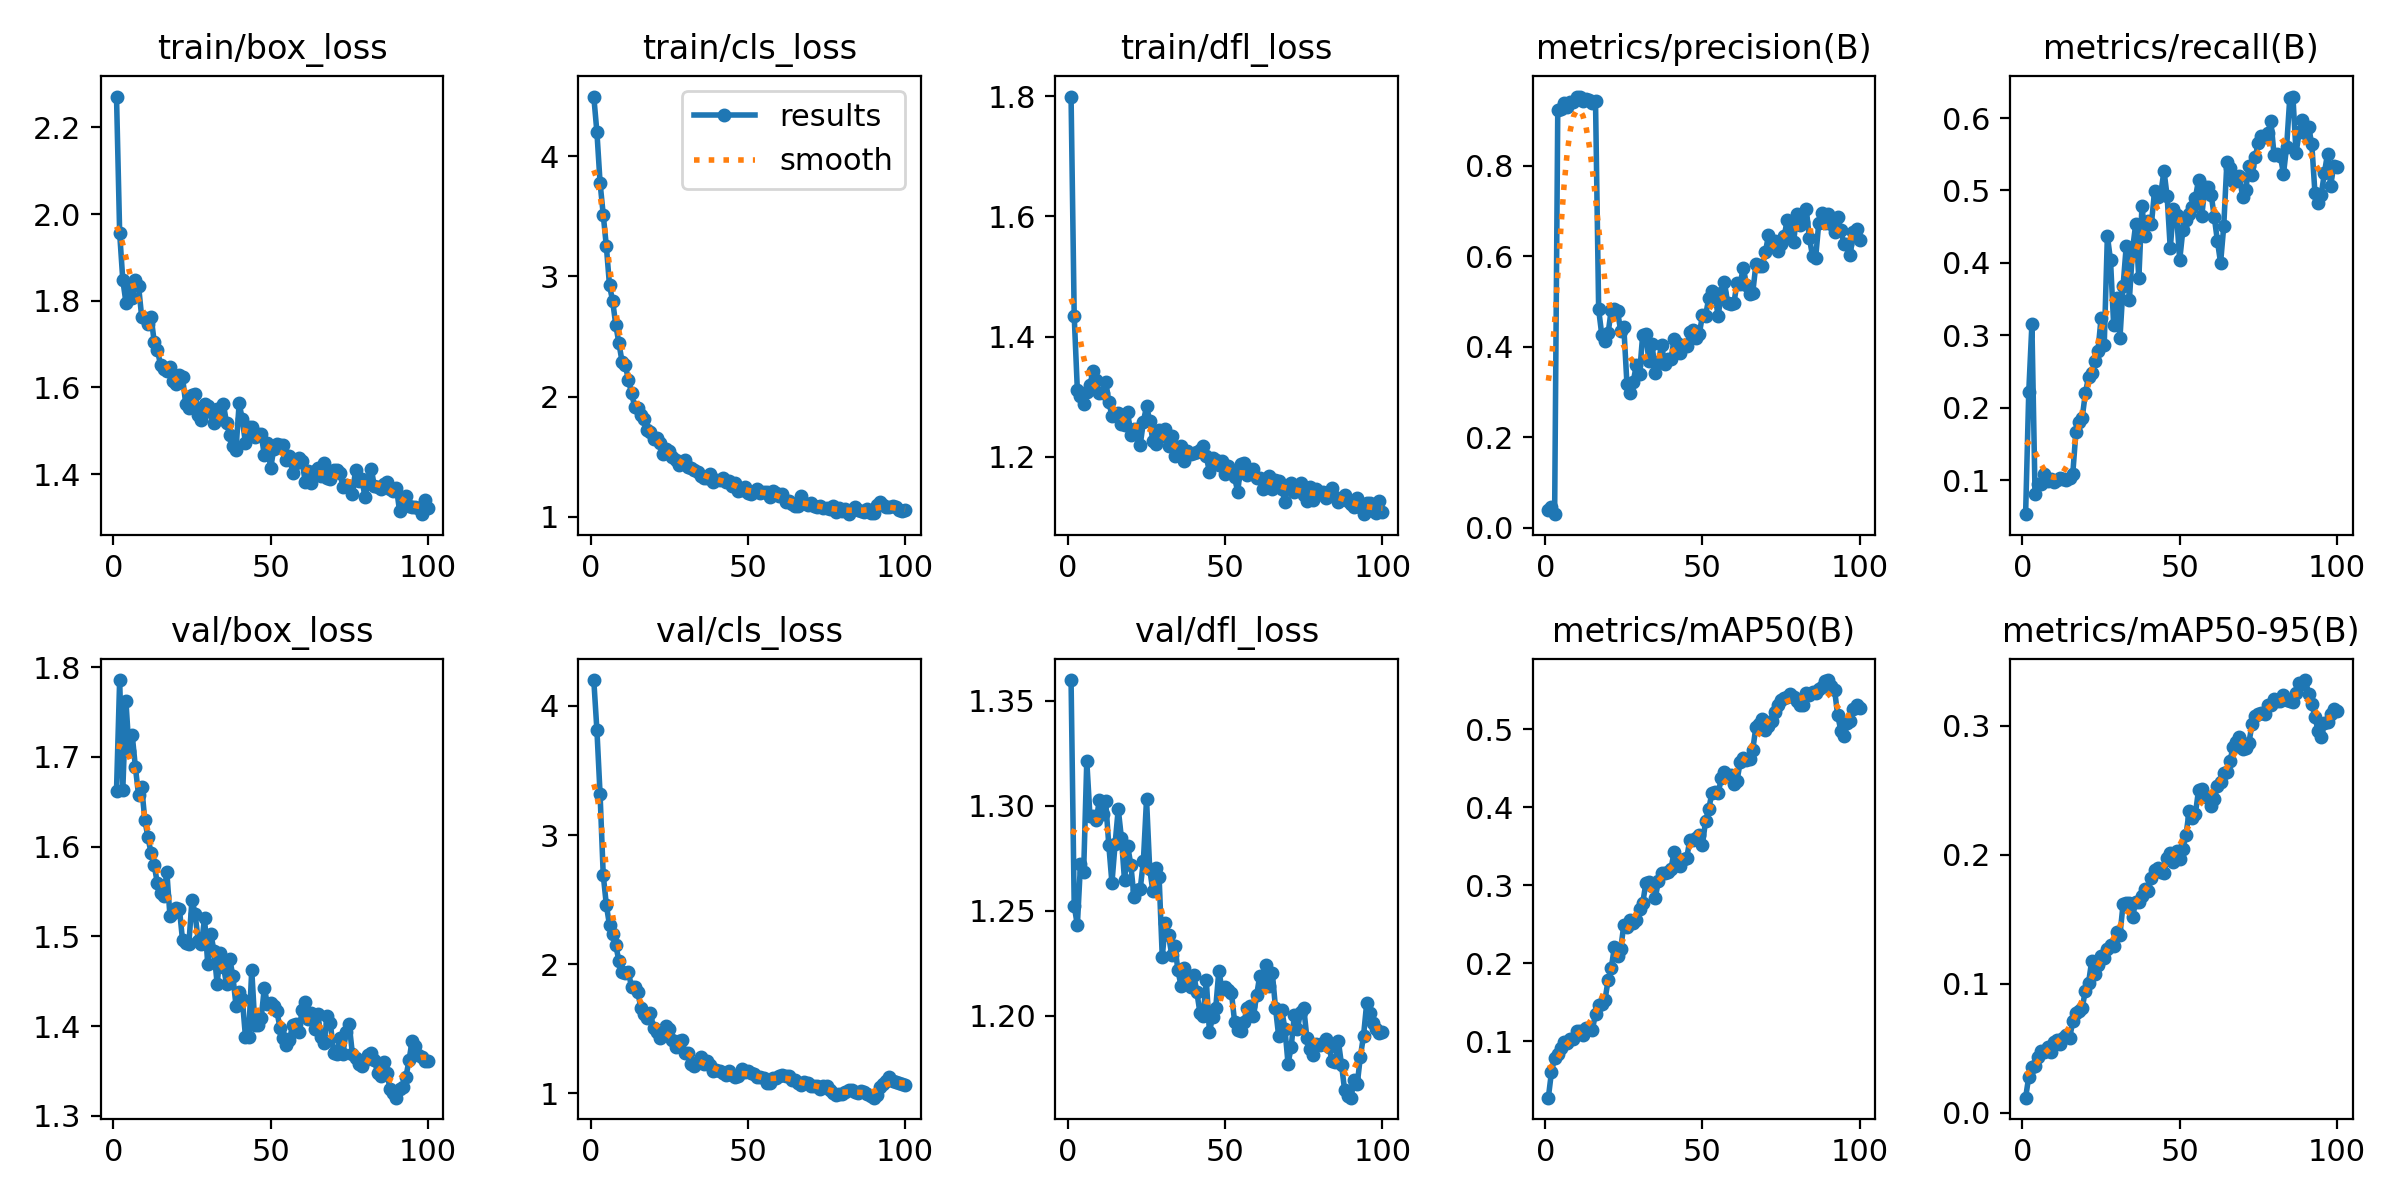

In [7]:

original_plot_path = ORIGINAL_PATHS['plot_res']
img_original = Image.open(original_plot_path)
display(img_original)


### Training Results Visualization

The plot below shows key training metrics (loss curves, precision, recall, mAP) across all epochs for the original dataset model.

In [8]:
BEST_WEIGHTS_PATH = ORIGINAL_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_original.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/black bean_yolo11n_original.pt


## Model training on Augmented Dataset

In [10]:
augmented_model = YOLO(MODEL_NAME)

augmented_train_results = augmented_model.train(
    data=str(DATA_CONFIG_AUG),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=AUGMENTED_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE,
    #workers=0,
    exist_ok=True
)

print(f"Augmented dataset model saved to: {AUGMENTED_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Black bean_augmented/black bean_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, 

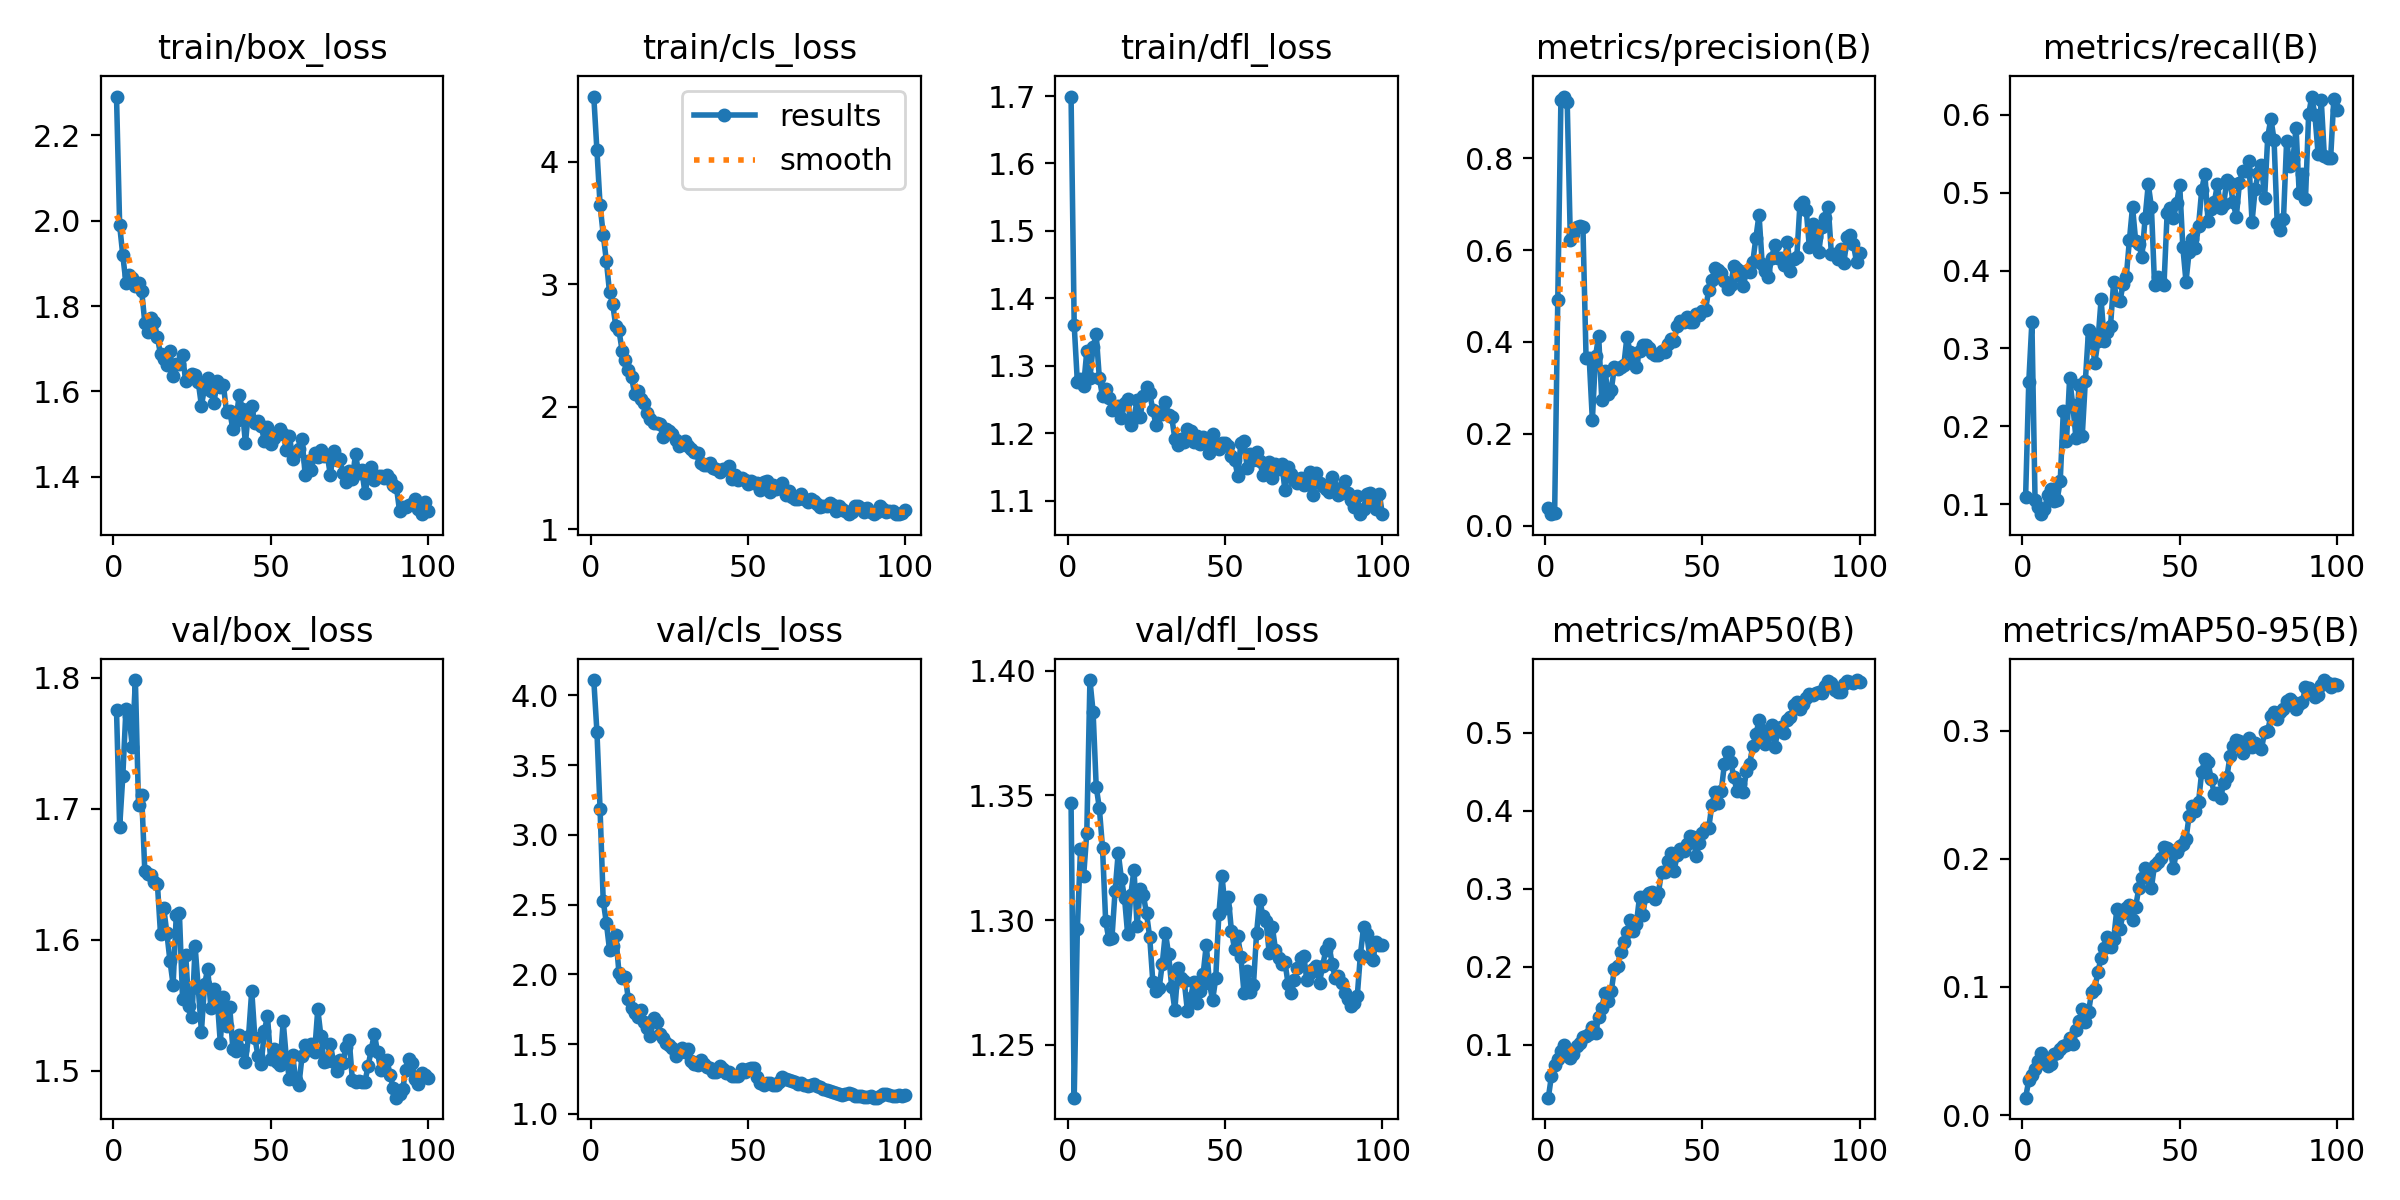

In [11]:

augmented_plot_path = AUGMENTED_PATHS['plot_res']
img_augmented = Image.open(augmented_plot_path)
display(img_augmented)

### Training Results Visualization

The plot below shows key training metrics (loss curves, precision, recall, mAP) across all epochs for the augmented dataset model.

In [12]:
BEST_WEIGHTS_PATH = AUGMENTED_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_augmented.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/black bean_yolo11n_augmented.pt


# Evaluation on test dataset

---

### Model trained on original dataset evaluation

In [29]:

BEST_MODEL_PATH = ORIGINAL_PATHS['weights'] 

print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
original_metrics = final_model.val(
    data=str(DATA_CONFIG_ORIGINAL), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(ORIGINAL_OUTPUT_DIR),
    name = "evaluation"
)

print(original_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {original_metrics.box.map:.4f}")
print(f"mAP50 (Test): {original_metrics.box.map50:.4f}")

if hasattr(original_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {original_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {original_metrics.box.mr:.4f}")

Loading best model from: runs/Black bean_original/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7361.4±1625.0 MB/s, size: 4850.5 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 92.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.6it/s 5.4s3.1ss
                   all         39        606      0.751      0.416      0.472      0.277
            Black bean         38        446      0.772      0.901      0.907      0.565
                  Flax          1          3          1          0          0          0
            

### Model trained on augmented dataset evaluation

In [30]:
BEST_MODEL_PATH = AUGMENTED_PATHS['weights'] 
print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
augmented_metrics = final_model.val(
    data=str(DATA_CONFIG_AUG), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(AUGMENTED_OUTPUT_DIR),
    name = "evaluation"
)

print(augmented_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {augmented_metrics.box.map:.4f}")
print(f"mAP50 (Test): {augmented_metrics.box.map50:.4f}")

if hasattr(augmented_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {augmented_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {augmented_metrics.box.mr:.4f}")

Loading best model from: runs/Black bean_augmented/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6524.4±2555.8 MB/s, size: 6175.5 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 93.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.6it/s 5.4s3.0ss
                   all         39        606      0.615      0.473      0.487      0.293
            Black bean         38        446       0.74      0.845      0.837      0.478
                  Flax          1          3          1          0          0          0
           

### Report

---

In [31]:
def extract_class_metrics(metrics_obj, label):

    evaluated_iids = metrics_obj.box.ap_class_index.tolist()
    
    ap50_arr = metrics_obj.box.ap50.flatten().tolist()
    ap_arr = metrics_obj.box.ap.flatten().tolist()

    full_class_names = metrics_obj.names
    
    nc_evaluated = len(ap50_arr) 
    
    data_list = []
    data_list_2 = []
    
    for i in range(nc_evaluated): 
        
        class_id = evaluated_iids[i]
        class_name = full_class_names[class_id]
        
        data_list.append({
            'Class': class_name, 
            f'mAP@0.5 ({label})': ap50_arr[i],
            f'mAP@0.5:0.95 ({label})': ap_arr[i]
        })

    df = pd.DataFrame(data_list)
    df.set_index('Class', inplace=True)
    return df

In [32]:
def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    total_time_ms = metrics_obj.speed['preprocess'] + metrics_obj.speed['inference'] + metrics_obj.speed['postprocess']
    fps_total = 1000 / total_time_ms 
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr

    #ap_small = metrics_obj.box.ap[7] if len(metrics_obj.box.ap) > 7 else 0 

    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)', 
                   #'AP_Small (APs)', 
                   'Total FPS'],
        label: [
            metrics_obj.box.map50, 
            metrics_obj.box.map, 
            precision, 
            recall,
            #ap_small, 
            fps_total,
        ]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [33]:

df_augmented_general = extract_general_metrics(augmented_metrics, 'Augmented')
df_original_general = extract_general_metrics(original_metrics, 'Original')

df_general_comparison = df_augmented_general.join(df_original_general, how='outer')
df_general_comparison['Difference'] = df_general_comparison['Augmented'] - df_general_comparison['Original']

print("\n--- Model Comparison: Overall Metrics  ---")
display(df_general_comparison.round(4))

df_augmented_class= extract_class_metrics(augmented_metrics, 'Augmented')
df_original_class= extract_class_metrics(original_metrics, 'Original')

df_class_comparison = df_augmented_class.join(df_original_class, how='outer').fillna(0)
df_class_comparison['Diff mAP@0.5'] = df_class_comparison['mAP@0.5 (Augmented)'] - df_class_comparison['mAP@0.5 (Original)'] 
df_class_comparison['Diff mAP@0.5:0.95'] = df_class_comparison['mAP@0.5:0.95 (Augmented)'] - df_class_comparison['mAP@0.5:0.95 (Original)']

print("\n--- Model Comparison: Class-Wise Details ---")
display(df_class_comparison.round(4))


--- Model Comparison: Overall Metrics  ---


,Augmented,Original,Difference
Metric,,,
Precision (P),0.6152,0.7506,-0.1354
Recall (R),0.4726,0.4158,0.0569
Total FPS,42.5608,35.0053,7.5556
mAP@0.5,0.4869,0.4722,0.0147
mAP@0.5:0.95,0.2931,0.2766,0.0165



--- Model Comparison: Class-Wise Details ---


,mAP@0.5 (Augmented),mAP@0.5:0.95 (Augmented),mAP@0.5 (Original),mAP@0.5:0.95 (Original),Diff mAP@0.5,Diff mAP@0.5:0.95
Class,,,,,,
Black bean,0.8375,0.4781,0.9070,0.5654,-0.0695,-0.0873
Flax,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Horseweed,0.7546,0.3436,0.6855,0.2496,0.0691,0.0940
Kochia,0.5539,0.3354,0.5451,0.3116,0.0088,0.0238
Lentil,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Ragweed,0.5397,0.3007,0.5328,0.3015,0.0069,-0.0008
Redroot Pigweed,0.8389,0.6132,0.7903,0.5575,0.0486,0.0556
Soybean,0.2764,0.2002,0.2670,0.1798,0.0094,0.0205
Waterhemp,0.5809,0.3664,0.5219,0.3241,0.0590,0.0424


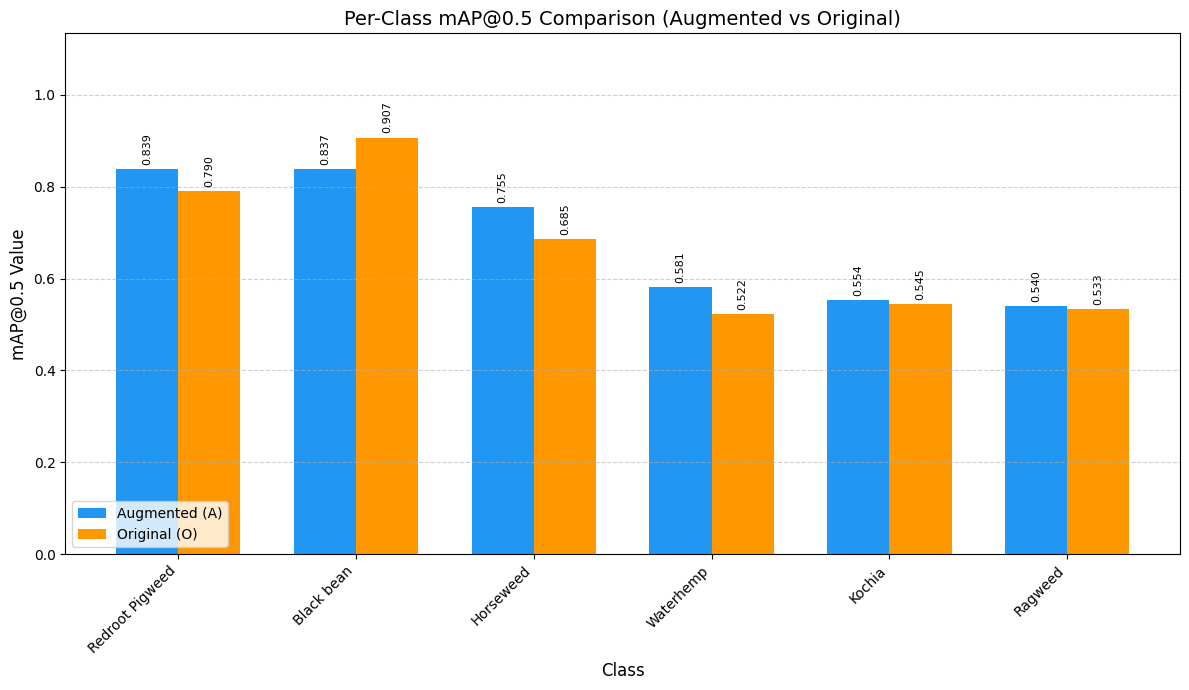

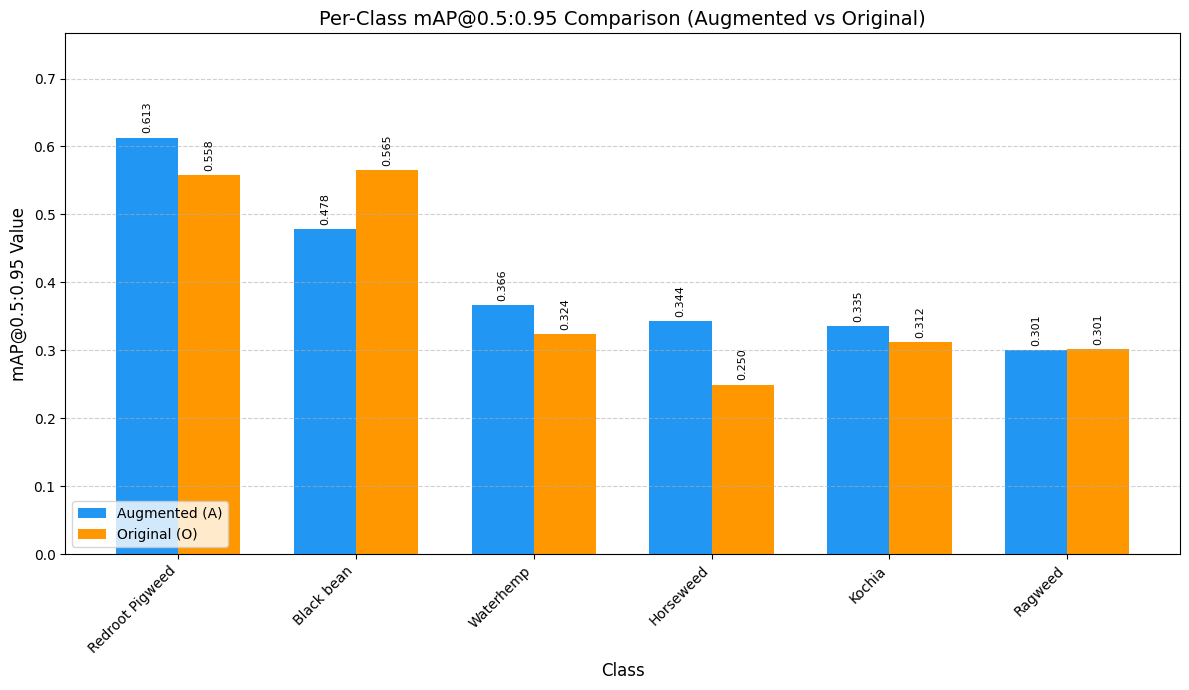

In [34]:
def create_grouped_ap_chart(df, metric_base_name, title):
    """Generates a grouped bar chart for a single AP metric (Augmented vs Original)."""

    augmented_col = f'{metric_base_name} (Augmented)'
    original_col = f'{metric_base_name} (Original)'
    
    if not all(col in df.columns for col in [augmented_col, original_col]):
        print(f"Error: Columns '{augmented_col}' or '{original_col}' not found in DataFrame.")
        return

    df_chart = df[[augmented_col, original_col]].sort_values(by=augmented_col, ascending=False)
    
    bar_width = 0.35
    classes = df_chart.index
    r = np.arange(len(classes))
    
    fig, ax = plt.subplots(figsize=(12, 7))

    bars1 = ax.bar(r - bar_width/2, df_chart[augmented_col], width=bar_width, 
                   label='Augmented (A)', color='#2196F3', edgecolor='none')
    bars2 = ax.bar(r + bar_width/2, df_chart[original_col], width=bar_width, 
                   label='Original (O)', color='#FF9800', edgecolor='none')

    ax.set_ylabel(f'{metric_base_name} Value', fontsize=12)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(r)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend(loc='lower left')
    ax.set_ylim(0, df_chart.max().max() * 1.25)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, rotation=90)

    add_labels(bars1)
    add_labels(bars2)

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    #filename = f'{metric_base_name.lower().replace("@", "_")}_comparison_class.png'
    plt.show() 
    #print(f"\nChart saved as {filename}")

TARGET_CLASSES = [
    'Black bean', 'Horseweed', 'Kochia', 
    'Ragweed', 'Redroot Pigweed', 'Waterhemp'
]

df_plot_filtered = df_class_comparison.loc[df_class_comparison.index.intersection(TARGET_CLASSES)]

create_grouped_ap_chart(
    df_plot_filtered, 
    metric_base_name='mAP@0.5', 
    title='Per-Class mAP@0.5 Comparison (Augmented vs Original)'
)

create_grouped_ap_chart(
    df_plot_filtered, 
    metric_base_name='mAP@0.5:0.95', 
    title='Per-Class mAP@0.5:0.95 Comparison (Augmented vs Original)'
)

## Comparative Analysis

The following tables compare the performance of both models on the test dataset. Positive differences indicate improvements in the augmented model.

**mAP@0.5** - Mean Average Precision at IoU ≥50%. Measures if the model successfully identifies the object with reasonable overlap.

**mAP@0.5:0.95** - Mean of Average Precisions across IoU thresholds from 50% to 95%. It's a highly sensitive metric that measures how precisely the model predicts the exact location and shape of the bounding box.

A high mAP@0.5 but low mAP@0.5:0.95 means the model detects objects well but struggles with precise localization (it can't pinpoint the exact borders of the weed).

* **Black bean** - decrease in both mAP@0.5 and mAP@0.5:0.95, which is expected as the number of samples for this crop was decreased in dataset.
* **Horseweed** - Both metrics increased visibly and the model tends to localize instances better.
* **Kochia** - Slight increase in both metrics.
* **Ragweed** - increase in mAP@50 metric and no mprovement in the model localization precision decreased very slightly (mAP@0.5:0.95) 
* **Redroot Pigweed** - Visible imporvement in both metricts.
* **Waterhemp** - visible increase in both metrics.

The remaining classes represent residual crops, that are not important in our ablation study, as we focus only on weeds.

Overall, the results are as expected. We can see visible, but still quite small improvement in both mAP@0.5 and mAP@0.5:0.95 in 4 among 5 weeds classes, and a decrease in majority class scores. This shows that the augmentation method works and has potential, but is not that effective, as the majoroty classes still dominates the dataset after data preprocessing.

**FPS**
* Total FPS - End-to-End FPS for full pipeline: preprocess + inference + postprocess

Total FPS slightly decreased after augmentation, but its still on the similar level to the original dataset.

### Visual Comparison: Precision-Recall Curves

The side-by-side comparison below shows the precision-recall curves for both models across all classes. These curves illustrate the trade-off between precision and recall at different confidence thresholds.

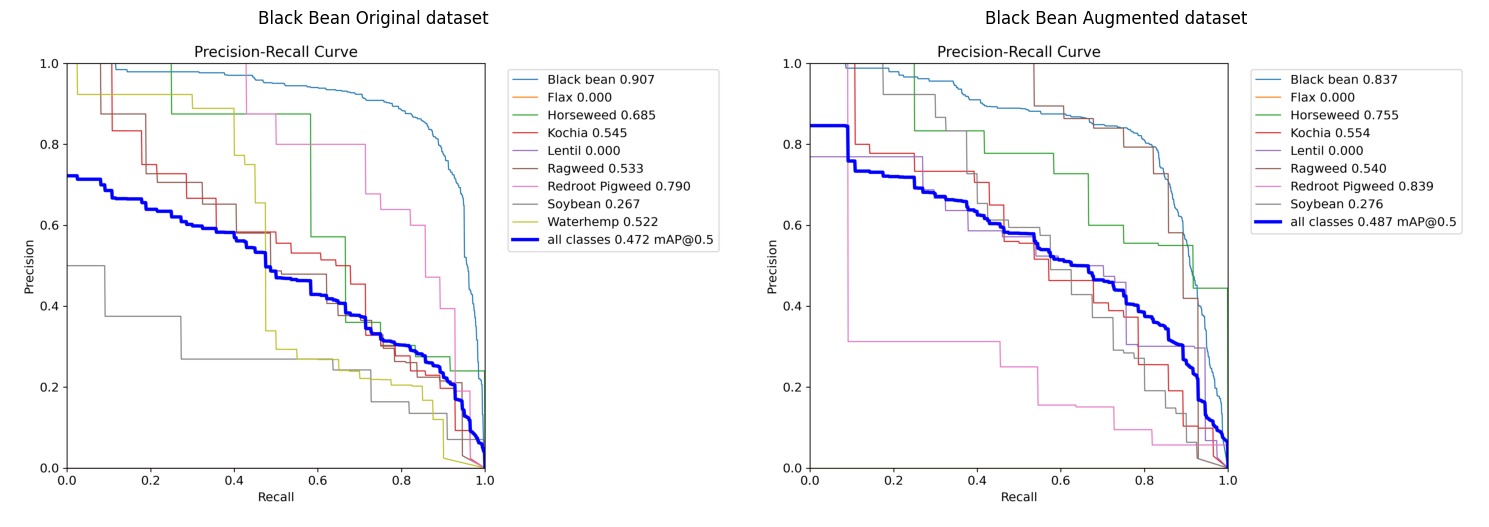

In [35]:
PATH_ORIGINAL = ORIGINAL_PATHS['plot_pr']
PATH_AUGMENTED = AUGMENTED_PATHS['plot_pr']

TITLE_ORIGINAL = ORIGINAL_PROJECT_NAME.replace('_', ' ').title()
TITLE_AUGMENTED = AUGMENTED_PROJECT_NAME.replace('_', ' ').title()

%matplotlib inline

try:
    img_original = Image.open(PATH_ORIGINAL)
    img_augmented = Image.open(PATH_AUGMENTED)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(img_original)
    axes[0].set_title(f'{TITLE_ORIGINAL} dataset')
    axes[0].axis('off') 

    axes[1].imshow(img_augmented)
    axes[1].set_title(f'{TITLE_AUGMENTED} dataset')
    axes[1].axis('off') 

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: One or both PR curve plots were not found.")
    print("Please ensure both the Baseline and Augmented models have been trained and have saved 'BoxPR_curve.png' in the correct folders.")
except Exception as e:
    print(f"An unexpected error occurred during image display: {e}")

**How to interprate PR curves?**
* Precision (how many detections were correct) at all confidence thresholds
* Recall (how many true objects were found) at all confidence thresholds

* Higher curve = better performance
* Smoother curve = model generalizes better
* Right shift (higher recall) = fewer missed detections
* Upward shift (higher precision) = fewer false positives

PR curves confirm that augmentation improves recall and stabilizes predictions for nearly all weed classes while slightly harming the crop class.

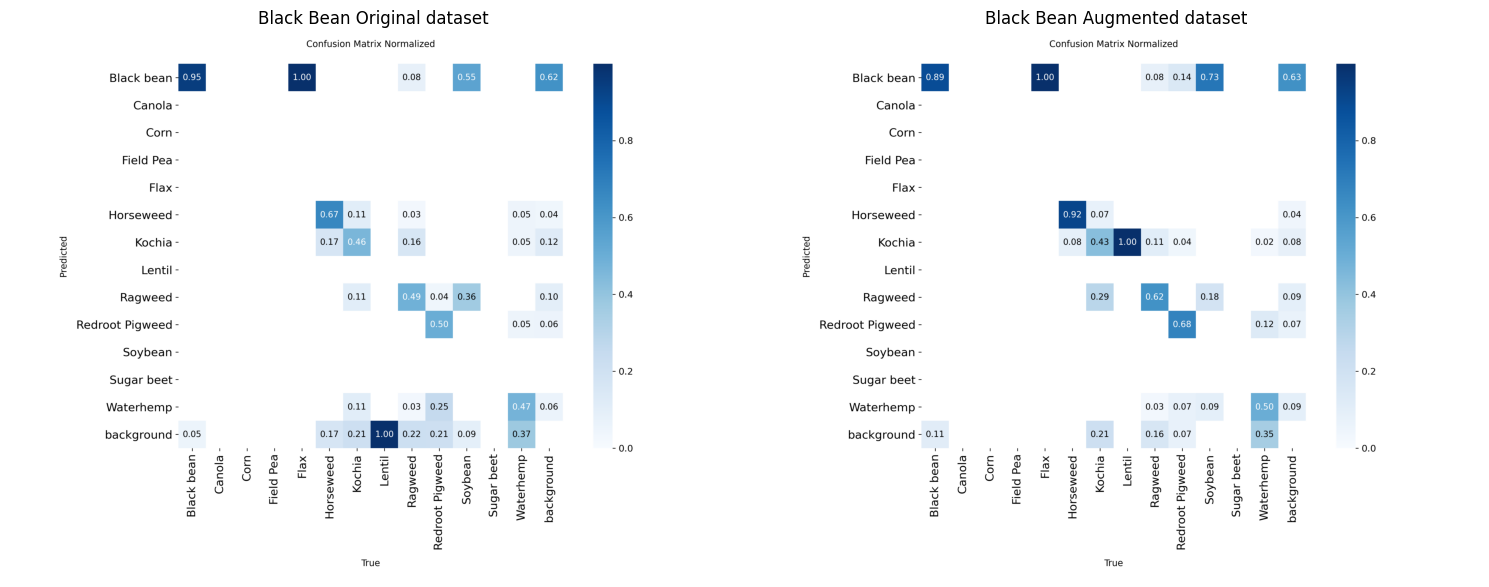

In [36]:
PATH_ORIGINAL = ORIGINAL_PATHS['plot_cm']
PATH_AUGMENTED = AUGMENTED_PATHS['plot_cm']

TITLE_ORIGINAL = ORIGINAL_PROJECT_NAME.replace('_', ' ').title()
TITLE_AUGMENTED = AUGMENTED_PROJECT_NAME.replace('_', ' ').title()

%matplotlib inline

try:
    img_original = Image.open(PATH_ORIGINAL)
    img_augmented = Image.open(PATH_AUGMENTED)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(img_original)
    axes[0].set_title(f'{TITLE_ORIGINAL} dataset')
    axes[0].axis('off') 

    axes[1].imshow(img_augmented)
    axes[1].set_title(f'{TITLE_AUGMENTED} dataset')
    axes[1].axis('off') 

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: One or both CM curve plots were not found.")
except Exception as e:
    print(f"An unexpected error occurred during image display: {e}")

**Confusion matrices show:**
* Diagonal elements = correct detections
* Off-diagonals = misclassifications
* Empty rows/columns = classes rarely predicted

Confusion matrices clearly show that augmentation reduces false negatives and misclassifications for most weeds.
The only class negatively affected is Black Bean, which becomes slightly less distinct.